<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%matplotlib inline

from google.colab import drive as my_drive
import os
from time import time
from pathlib import Path
import shutil
from tqdm.notebook import tqdm_notebook

import torch
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import cv2
from PIL import Image

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
my_drive.mount('/content/gdrive/')

DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
!nvidia-smi

Mounted at /content/gdrive/
Sun Jun 20 14:01:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
%cd ./gdrive/MyDrive/DLS
!mkdir "./dls_faces"

# unzip
!unzip -q ./faces_dataset_small.zip -d dls_faces

# rm mac
shutil.rmtree('./dls_faces/__MACOSX/')
shutil.rmtree('./dls_faces/faces_dataset_small/04000/')

/content/gdrive/MyDrive/DLS


In [4]:
image_size = 128

full_path = Path('./dls_faces/faces_dataset_small/')
!mkdir "./dls_faces/resize_dls_faces"
new_path = "./dls_faces/resize_dls_faces/"

i=0
for file_path in full_path.glob("*.png"):
    image = Image.open(file_path)
    image = image.convert('RGB')
    image = image.resize((image_size, image_size))
    image.save(os.path.join(new_path, file_path.stem+'.jpg'))
    i += 1
    if i >= 500 and i%500 == 0:
        print(f"{i} images done!")

!rm -r "/content/gdrive/MyDrive/DLS/dls_faces/faces_dataset_small"

500 images done!
1000 images done!
1500 images done!
2000 images done!
2500 images done!
3000 images done!


In [5]:
def get_dataloader(batch_size, stats, PATH):

    dataset = ImageFolder(PATH, 
                          transform=tt.Compose(
                              [tt.ToTensor(),
                               tt.Normalize(*stats)]
                               )
                          )    
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    return dataloader

image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
IMAGE_PATH = "/content/gdrive/MyDrive/DLS/dls_faces/"

dataloader = get_dataloader(batch_size, stats, IMAGE_PATH)
print(len(dataloader.dataset))

3143


In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=24):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=24):
    for images, _ in dl:
        show_images(images, nmax)
        break

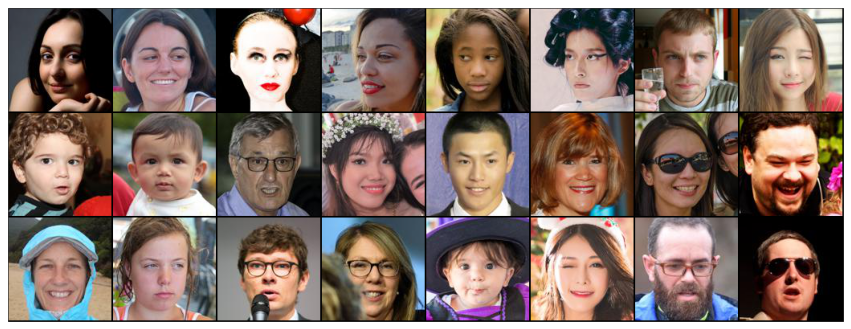

In [7]:
show_batch(dataloader)

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
dataloader = DeviceDataLoader(dataloader, DEVICE)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [10]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64   

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32    

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16

    nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 4 x 4

    nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
    )

In [11]:
latent_size = 512

In [12]:
generator = nn.Sequential(
    # in: 512 x 1 x 1    
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4    

    nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16    

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

torch.Size([128, 3, 128, 128])


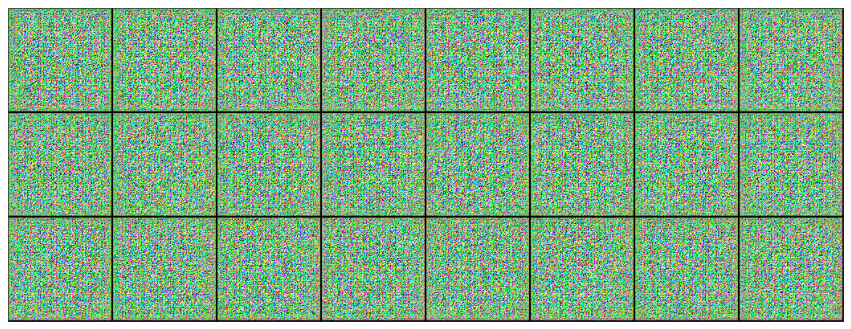

In [13]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [14]:
model = {
    "discriminator": discriminator.to(DEVICE),
    "generator": generator.to(DEVICE)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 1e-3
epochs = 200

In [15]:
FAKES = "/content/gdrive/MyDrive/DLS/fakes"
W_PATH = "/content/gdrive/MyDrive/DLS/weights"
!mkdir {W_PATH}
!mkdir {FAKES}

def save_samples(index, show=True):
    latent_tensor = torch.randn(24, latent_size, 1, 1, device=DEVICE)
    fake_images = generator(latent_tensor).cpu()
    fake_fname = f'fake_{index}.png'

    if os.path.exists(os.path.join(FAKES, fake_fname)):
      os.remove(os.path.join(FAKES, fake_fname))

    save_image(denorm(fake_images), os.path.join(FAKES, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        show_images(fake_images)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [17]:
def fit(model, criterion, epochs, lr, start=1):
  
    since = time()
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in tqdm_notebook(range(epochs), desc="Iterate the epochs"):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm_notebook(dataloader, desc="Iterate the batches", leave=False):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = 0.4 * torch.rand(real_images.size(0), 1, device=DEVICE) + 0.7
            
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = 0.2 * torch.rand(real_images.size(0), 1, device=DEVICE)

            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=DEVICE)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, time: {} min".format(
            epoch+start, epochs+start-1, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1], (time()-since)//60))   
        
        if (epoch + 1) % 50 == 0:         
          save_samples(epoch+start, show=True)
          torch.save(model['discriminator'].state_dict(), os.path.join(W_PATH, 'discriminator_' + str(epoch+start) + '.pth'))
          torch.save(model['generator'].state_dict(), os.path.join(W_PATH, 'generator_' + str(epoch+start) + '.pth'))
          
        if (epoch + 1) % 50 == 0:
            # clear_output(wait=True)
            plot_gen_metrics(fake_images.detach().cpu(), losses_g, losses_d, real_scores, fake_scores, epoch, start)

    print("Training is done! Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, time: {:.2f} min".format(
        epoch+start, epochs+start-1, 
        losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1], (time()-since)//60))   

    return model  

In [18]:
def plot_gen_metrics(fake_images, losses_g, losses_d, real_scores, fake_scores, epoch, start):
    images = denorm(fake_images[:24]).permute(0, 2, 3, 1).numpy()
    plt.figure(figsize=(15, 9))

    plt.subplot(2,1,1)
    plt.plot(losses_d, '-')
    plt.plot(losses_g, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Discriminator', 'Generator'])
    plt.title('Losses')
    
    plt.subplot(2,1,2)
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(['Real', 'Fake'])
    plt.title('Scores')
    
    plt.suptitle(f"epoch: {epoch + start} \
    - loss_g: {losses_g[-1]:.04} \
    - loss_d: {losses_d[-1]:.04} \
    - r_score: {real_scores[-1]:.04} \
    - f_score: {fake_scores[-1]:.04}",
                      fontsize=16)
    plt.tight_layout()          
    plt.show();

In [19]:
# import gc
# model=None
# gc.collect()

In [20]:
model = fit(model, criterion, epochs, lr, start=1)

Output hidden; open in https://colab.research.google.com to view.

Лосс адекватный, как в семинаре  
Случайно перепутал название лейблов в функции отрисовки графика лоссов  
В коде поправил, но перезапускать не стал

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

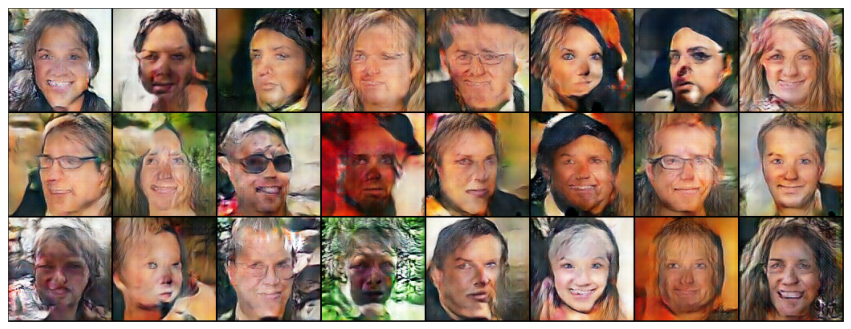

In [21]:
generator = generator.to(DEVICE)
generator.load_state_dict(torch.load(os.path.join(W_PATH, 'generator_200.pth')))

n_images = 24

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)

with torch.no_grad():
  generator.eval()
  fake_images = generator(fixed_latent).cpu()

show_images(fake_images)

Интересные рожи, но видно, что фейковые

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [22]:
real_images = torch.Tensor().to(DEVICE)

for images, _ in dataloader:
  real_images = torch.cat((real_images, images.view(images.size(0),-1)), dim=0)

real_images = real_images.detach().cpu()

full_size = real_images.shape[0]
batch_size = 128
N = int(full_size /  batch_size)

fake_images = torch.Tensor().to(DEVICE)

with torch.no_grad():
  generator.eval()
  for i in range(N):
    latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
    images = generator(latent)
    fake_images = torch.cat((fake_images, images.view(images.size(0),-1)), dim=0)

fake_images = fake_images.detach().cpu()

In [23]:
# Склеим вектора
all_images = torch.cat((real_images, fake_images), dim=0).numpy()

# Для  LeaveOneOut() и KNeighborsClassifier(n_neighbors=1) не хватает оперативной памяти
# Возспользуемся методом, предложенным в чате по поиску соседа через евклидову норму

N = len(all_images)
res = 0

n_id = [None for _ in range(N)]
n_dist = [None for _ in range(N)]

for i in tqdm_notebook(range(N)):
  for j in range(i + 1, N):
    cur_dist = np.linalg.norm(all_images[i] - all_images[j])
    if (n_id[i] is None) or (cur_dist < n_dist[i]):
      n_dist[i] = cur_dist
      n_id[i] = j
    if (n_id[j] is None) or (n_dist[j] > cur_dist):
      n_dist[j] = cur_dist
      n_id[j] = i
  if (i < (N / 2) and n_id[i] < (N / 2)) or (i >= (N / 2) and n_id[i] >= (N / 2)):
    res += 1

In [24]:
accuracy = res / N
print(f"Accuracy = {accuracy*100:0.3}%")

Accuracy = 77.2%


В идеале, мы должны получить Accuracy в районе 50%. Однако наш результат указывает на то, что мы и так видим, фейковые изображения все таки отличимы от реальных

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [25]:
%%time
tsne_results = TSNE(n_components=2, random_state=123, n_jobs=-1, ).fit_transform(all_images)

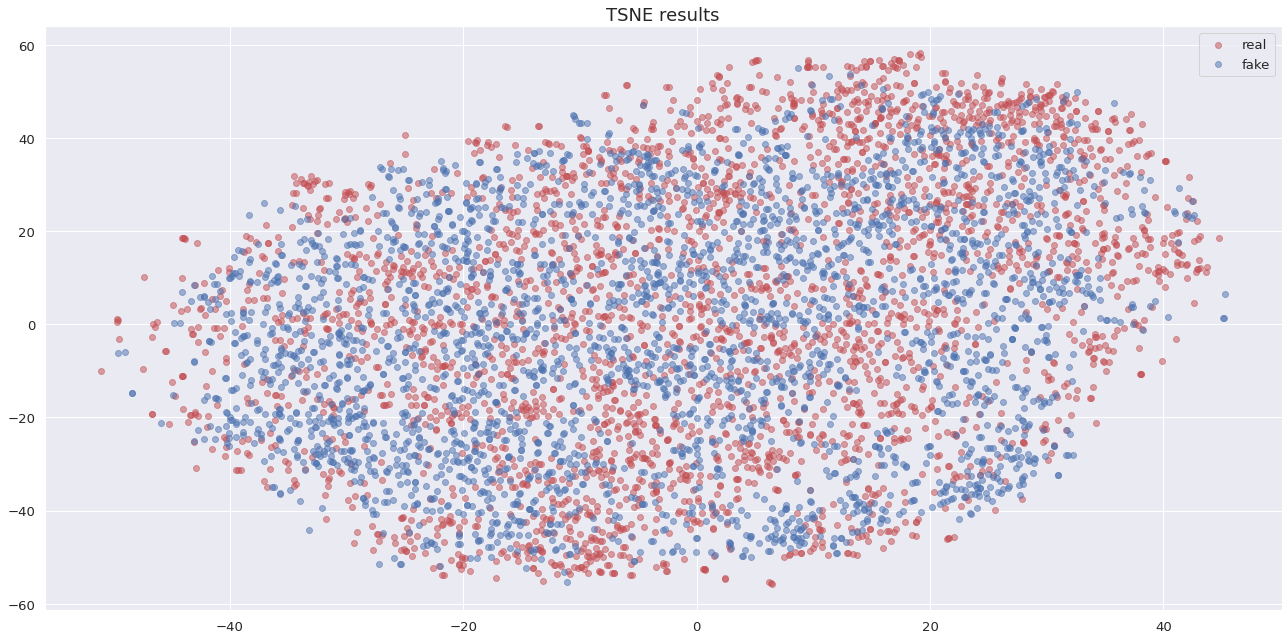

In [27]:
# Отрисуем точки, соответствующие реальным и сгенерированным изображениям
half = int(tsne_results.shape[0] / 2)

plt.figure(figsize=(18, 9))

plt.scatter(tsne_results[:half, 0], 
            tsne_results[:half, 1], 
            c='r', 
            alpha=0.5, 
            label='real'
            )
plt.scatter(tsne_results[half:, 0], 
            tsne_results[half:, 1], 
            c='b', 
            alpha=0.5, 
            label='fake'
            )      

plt.title('TSNE results', fontsize=18)  
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Прокомментируйте получившийся результат:

Результат получился неутешительный, визуально кажется, что кластеры присутствуют, но возможно, я выдаю желаемое за действительность